In [32]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal
import numpy as np

# ======================================================
# 1. HYPERPARAMÈTRES PPO
# ======================================================
# Ces valeurs sont standards et stables pour PPO sur MuJoCo
config = {
    "env_name": "Hopper-v5",
    "gamma": 0.99,              # Facteur de discount (importance du futur)
    "lr": 3e-4,                 # Learning rate (valeur classique PPO)
    "clip_eps": 0.2,            # Clipping PPO pour limiter les updates trop grandes
    "epochs": 800,              # Nombre d'itérations d'entraînement
    "steps_per_epoch": 2048,    # Nombre de pas collectés avant chaque update
    "batch_size": 64,           # Taille des mini-batches
    "entropy_coef": 0.0,        # Bonus d'exploration
    "gae_lambda": 0.95,         # Paramètre GAE (bias / variance trade-off)
    "update_epochs": 10         # Nombre de passes SGD par batch PPO
}

# Utilisation du GPU si disponible
device = "cuda" if torch.cuda.is_available() else "cpu"

# ======================================================
# 2. ENVIRONNEMENT
# ======================================================
# Hopper est très sensible à l'échelle des observations,
# la normalisation est donc ESSENTIELLE pour la convergence
env = gym.make(config["env_name"])
env = gym.wrappers.NormalizeObservation(env)

obs_dim = env.observation_space.shape[0]   # Dimension des observations
act_dim = env.action_space.shape[0]        # Dimension des actions

# ======================================================
# 3. RÉSEAU DE POLITIQUE (ACTOR)
# ======================================================
# La politique produit :
# - une moyenne mu
# - un écart-type std
# pour une distribution gaussienne par dimension d'action
class Policy(nn.Module):
    def __init__(self):
        super().__init__()

        # Réseau partagé (feature extractor)
        self.base = nn.Sequential(
            nn.Linear(obs_dim, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh()
        )

        # Tête pour la moyenne des actions
        self.mu = nn.Linear(64, act_dim)

        # Tête pour le log-écart-type (dépend de l'état)
        self.log_std = nn.Linear(64, act_dim)

    def forward(self, x):
        h = self.base(x)

        mu = self.mu(h)

        # Clamp pour éviter des variances trop grandes ou trop petites
        log_std = self.log_std(h).clamp(-20, 2)
        std = torch.exp(log_std)

        return mu, std

# ======================================================
# 4. RÉSEAU DE VALEUR (CRITIC)
# ======================================================
# Estime V(s) pour calculer les avantages (GAE)
class Value(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x).squeeze(-1)

# Initialisation des réseaux
policy = Policy().to(device)
value = Value().to(device)

# Optimiseurs séparés Actor / Critic
optimizer_policy = optim.Adam(policy.parameters(), lr=config["lr"])
optimizer_value = optim.Adam(value.parameters(), lr=config["lr"])

# ======================================================
# 5. COLLECTE DES TRAJECTOIRES
# ======================================================
def collect_trajectories():
    """
    Collecte un batch de transitions en utilisant la politique courante.
    Les actions sont bornées avec tanh pour respecter l'espace d'action.
    """
    obs, _ = env.reset()

    obs_buf, act_buf = [], []
    rew_buf, logp_buf = [], []
    val_buf, done_buf = [], []

    policy.eval()
    value.eval()

    for _ in range(config["steps_per_epoch"]):
        obs_t = torch.tensor(obs, dtype=torch.float32).to(device)

        with torch.no_grad():
            # Distribution gaussienne de la politique
            mu, std = policy(obs_t)
            dist = Normal(mu, std)

            # Action échantillonnée (espace non borné)
            raw_act = dist.sample()

            # Action bornée dans [-1, 1]
            act = torch.tanh(raw_act)

            # Log-probabilité de l'action NON bornée (PPO standard)
            logp = dist.log_prob(raw_act).sum()

            # Valeur estimée par le critic
            val = value(obs_t)

        next_obs, rew, terminated, truncated, _ = env.step(act.cpu().numpy())
        done = terminated or truncated

        # Stockage dans le buffer
        obs_buf.append(obs)
        act_buf.append(raw_act)
        rew_buf.append(rew)
        logp_buf.append(logp)
        val_buf.append(val)
        done_buf.append(done)

        obs = next_obs
        if done:
            obs, _ = env.reset()

    return obs_buf, act_buf, rew_buf, logp_buf, val_buf, done_buf

# ======================================================
# 6. GAE — GENERALIZED ADVANTAGE ESTIMATION
# ======================================================
def compute_gae(rews, vals, dones):
    """
    Calcule les avantages (GAE) et les returns.
    Permet de réduire la variance tout en gardant un biais contrôlé.
    """
    advs = []
    gae = 0.0

    # On ajoute V(s_{T+1}) = 0
    vals = [v.item() for v in vals] + [0.0]

    for t in reversed(range(len(rews))):
        delta = rews[t] + config["gamma"] * vals[t+1] * (1 - dones[t]) - vals[t]
        gae = delta + config["gamma"] * config["gae_lambda"] * (1 - dones[t]) * gae
        advs.insert(0, gae)

    advs = torch.tensor(advs, dtype=torch.float32).to(device)
    returns = advs + torch.tensor(vals[:-1]).to(device)

    # Normalisation des avantages (TRÈS IMPORTANT pour PPO)
    advs = (advs - advs.mean()) / (advs.std() + 1e-8)

    return advs, returns

# ======================================================
# 7. BOUCLE D'ENTRAÎNEMENT PPO
# ======================================================
for epoch in range(config["epochs"]):

    # 1) Collecte des données
    obs_buf, act_buf, rew_buf, logp_buf, val_buf, done_buf = collect_trajectories()

    # 2) Calcul des avantages et returns
    advs, returns = compute_gae(rew_buf, val_buf, done_buf)

    # Conversion en tenseurs
    obs_t = torch.tensor(obs_buf, dtype=torch.float32).to(device)
    act_t = torch.stack(act_buf).to(device)
    old_logp_t = torch.stack(logp_buf).to(device)

    policy.train()
    value.train()

    # 3) Mise à jour PPO (plusieurs passes SGD)
    for _ in range(config["update_epochs"]):
        idx = np.random.permutation(len(obs_buf))

        for start in range(0, len(obs_buf), config["batch_size"]):
            batch = idx[start:start + config["batch_size"]]

            # Nouvelle politique
            mu, std = policy(obs_t[batch])
            dist = Normal(mu, std)
            new_logp = dist.log_prob(act_t[batch]).sum(dim=-1)

            # Ratio PPO
            ratio = torch.exp(new_logp - old_logp_t[batch])

            # Objectif PPO avec clipping
            surr1 = ratio * advs[batch]
            surr2 = torch.clamp(ratio, 1 - config["clip_eps"], 1 + config["clip_eps"]) * advs[batch]
            loss_policy = -torch.min(surr1, surr2).mean()

            # Loss du critic
            value_pred = value(obs_t[batch])
            loss_value = ((value_pred - returns[batch]) ** 2).mean()

            # Mise à jour Actor
            optimizer_policy.zero_grad()
            loss_policy.backward()
            optimizer_policy.step()

            # Mise à jour Critic
            optimizer_value.zero_grad()
            loss_value.backward()
            optimizer_value.step()

    # ==================================================
    # Affichage des performances
    # ==================================================
    print(f"Epoch {epoch+1}/{config['epochs']} terminée | Avg Reward = {np.mean(rew_buf):.2f}")



Epoch 1/800 terminée | Avg Reward = 0.79
Epoch 2/800 terminée | Avg Reward = 1.01
Epoch 3/800 terminée | Avg Reward = 1.45
Epoch 4/800 terminée | Avg Reward = 1.74
Epoch 5/800 terminée | Avg Reward = 1.93
Epoch 6/800 terminée | Avg Reward = 2.03
Epoch 7/800 terminée | Avg Reward = 2.06
Epoch 8/800 terminée | Avg Reward = 2.12
Epoch 9/800 terminée | Avg Reward = 2.13
Epoch 10/800 terminée | Avg Reward = 2.05
Epoch 11/800 terminée | Avg Reward = 2.13
Epoch 12/800 terminée | Avg Reward = 2.15
Epoch 13/800 terminée | Avg Reward = 2.15
Epoch 14/800 terminée | Avg Reward = 2.15
Epoch 15/800 terminée | Avg Reward = 2.13
Epoch 16/800 terminée | Avg Reward = 2.23
Epoch 17/800 terminée | Avg Reward = 2.15
Epoch 18/800 terminée | Avg Reward = 2.27
Epoch 19/800 terminée | Avg Reward = 2.27
Epoch 20/800 terminée | Avg Reward = 2.38
Epoch 21/800 terminée | Avg Reward = 2.38
Epoch 22/800 terminée | Avg Reward = 2.41
Epoch 23/800 terminée | Avg Reward = 2.36
Epoch 24/800 terminée | Avg Reward = 2.54
E

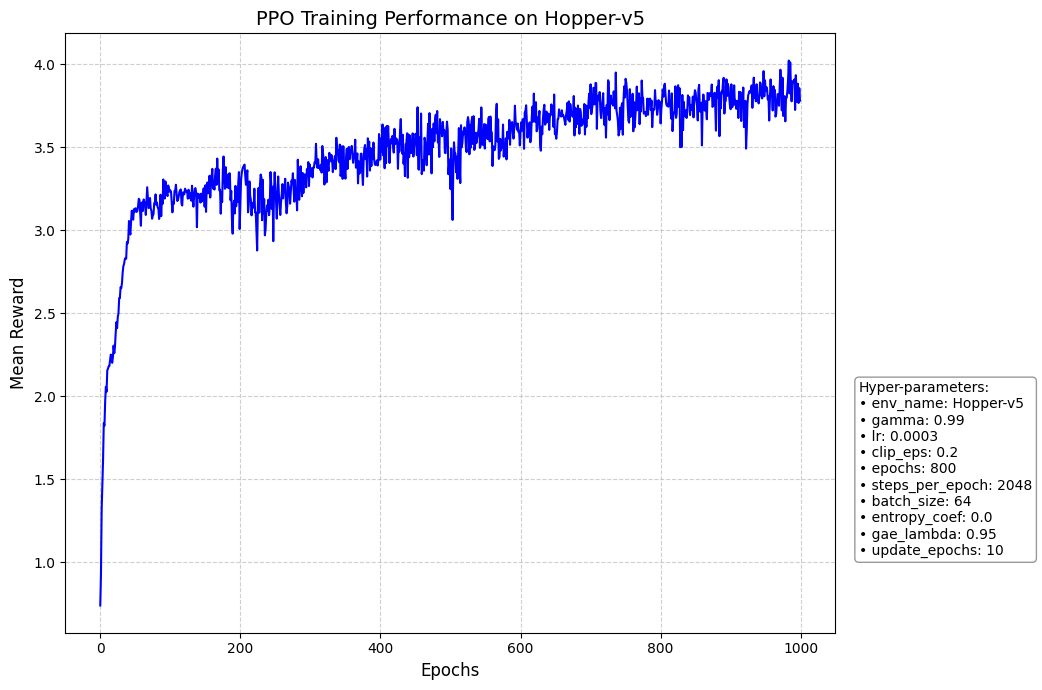

In [33]:
# --- Plot Final avec Hyperparamètres ---
plt.figure(figsize=(12, 7))
plt.plot(history_rewards, color='blue', label="Average Reward")
plt.title(f"PPO Training Performance on {config['env_name']}", fontsize=14)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Mean Reward", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

# Texte des hyperparamètres
hparams_text = "Hyper-parameters:\n" + "\n".join([f"• {k}: {v}" for k, v in config.items()])
plt.gcf().text(0.72, 0.20, hparams_text, fontsize=10, 
               bbox=dict(boxstyle='round', facecolor='white', edgecolor='gray', alpha=0.8))

plt.tight_layout()
plt.subplots_adjust(right=0.7) # Faire de la place pour le texte à droite
plt.show()

In [34]:
# --- Ligne finale ---
print("-" * 30)
print(f"✅ Entraînement terminé !")
print(f"🏆 Meilleure récompense moyenne enregistrée : {max(history_rewards):.2f}")
print("-" * 30)

------------------------------
✅ Entraînement terminé !
🏆 Meilleure récompense moyenne enregistrée : 4.02
------------------------------


In [38]:
import gymnasium as gym
import torch
from torch.distributions import Normal

device = "cuda" if torch.cuda.is_available() else "cpu"

env = gym.make("Hopper-v5", render_mode="human")
env = gym.wrappers.NormalizeObservation(env)

obs, _ = env.reset()
done = False
total_reward = 0

policy.eval()

while not done:
    obs_t = torch.tensor(obs, dtype=torch.float32).to(device)

    with torch.no_grad():
        mu, std = policy(obs_t)
        act = torch.tanh(mu)   # ACTION DÉTERMINISTE

    obs, reward, terminated, truncated, _ = env.step(act.cpu().numpy())
    done = terminated or truncated
    total_reward += reward

env.close()
print(f"Total reward: {total_reward:.1f}")


Total reward: 294.0


In [ ]:
#env Swimmer si besoin 


#on a vu que avec un  nb peu d'epoch bah caexplore mais exploite pas et ca augmente dans la reward puis redescend etcb...

In [ ]:
#800 epoch 70 min -> les reward moy pas fou max ~3 de reward  donc pas fou
# chgmt des hyp param et normalisation traject cllect...

## pour 1000 epoche ca va jusqua max 4.02 mais 79 min et reward final de l'agent est nul ie ~30... 